<a href="https://colab.research.google.com/github/ullola17/datos_masivos_02/blob/main/TelescopioDatos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook de aprendizaje no supervisado usando K-medias

**Palabras clave:
Análisis de Imágenes,
simulación de lluvias cósmicas,
aprendizaje automático (K-medias).**

In [ ]:
import pandas as pd #Biblioteca para importar datos.
import numpy as np #Biblioteca para crear arreglos.
import matplotlib.pyplot as plt #Biblioteca para plotear.
from sklearn.cluster import KMeans #Biblioteca para crear el algoritmo K-means (k-medias) para agrupamiento de datos
import seaborn as sns #Biblioteca para plotear datos con plantillas específicas.
from IPython.display import Image #Biblioteca para mostrar imágenes.
from google.colab import drive #Biblioteca para importar datos desde google drive.

import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Activation
from keras.layers import Dropout, Dense, Flatten, BatchNormalization

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split


import PIL # Checar para adquirir las imágenes


#Autores:
##Martínez Felipe Miguel de Jesús

#El siguiente conjunto de datos se obtuvo por las instituciones que acontinuación se presentan y su uso es únicamente para fines didácticos:

#Instituto de Física, UNAM, Mexico
#III. Physics Institute A, RWTH Aachen University, Germany
#Centro de Investigación en Computación, Instituto Politécnico Nacional, Mexico
#Instituto de Astronomía, UNAM, Mexico
#III. Physics Institute B, RWTH Aachen University, Germany
#Instituto Nacional de Astrofísica, Óptica y Electrónica, Mexico


## Imágenes y Base de datos

**Obtención de los archivos**

In [ ]:
!wget https://www.dropbox.com/s/0ho9lqzb6d8z192/HAWC.png?dl=0 -O HAWC.png
!wget https://www.dropbox.com/s/dlz4f2g5real519/CallistoTel001_Run002_Entry001_55Tels.png?dl=0 -O CallistoTel001_Run002_Entry001_55Tels.png
!wget https://www.dropbox.com/s/85w16nlesb7cz7x/Ceres_Tel001_Run002_Entry001_55Tels.png?dl=0 -O Ceres_Tel001_Run002_Entry001_55Tels.png
!wget https://www.dropbox.com/s/ojkxupe7dm55t70/Cleaning_Tel001_Run002_Entry001_55Tels.png?dl=0 -O Cleaning_Tel001_Run002_Entry001_55Tels.png
!wget https://www.dropbox.com/s/wy99ezotv49el49/example_callisto_gamma_4100m_1TeV_100TeV_55Tel_Area_250x250_fov8g.csv?dl=0 -O example_callisto_gamma_4100m_1TeV_100TeV_55Tel_Area_250x250_fov8g.csv

--2023-10-05 21:31:40--  https://www.dropbox.com/s/0ho9lqzb6d8z192/HAWC.png?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/0ho9lqzb6d8z192/HAWC.png [following]
--2023-10-05 21:31:41--  https://www.dropbox.com/s/raw/0ho9lqzb6d8z192/HAWC.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucce9e33efbe6869ee20246da197.dl.dropboxusercontent.com/cd/0/inline/CFActQlBA_AlZuMSHpmRkPO3czCqTxC6bSviXwp3lc2-Fdvypp3okQPXaUund5s7aHz5058Dtdx4toO0SaoKAt528QZzL4TMgkzNHmWH4fGFVj4INI17OO-tzIpl4fDA5PE/file# [following]
--2023-10-05 21:31:41--  https://ucce9e33efbe6869ee20246da197.dl.dropboxusercontent.com/cd/0/inline/CFActQlBA_AlZuMSHpmRkPO3czCqTxC6bSviXwp3lc2-Fdvypp3okQPXaUund5s7aHz5058Dtdx4toO0SaoKAt528QZzL4TMgkzNHmWH4fGFVj4INI17OO-tzIpl4fD

**Simulación de chubascos o cascádas atmosféricas (rayos cósmicos gamma)**

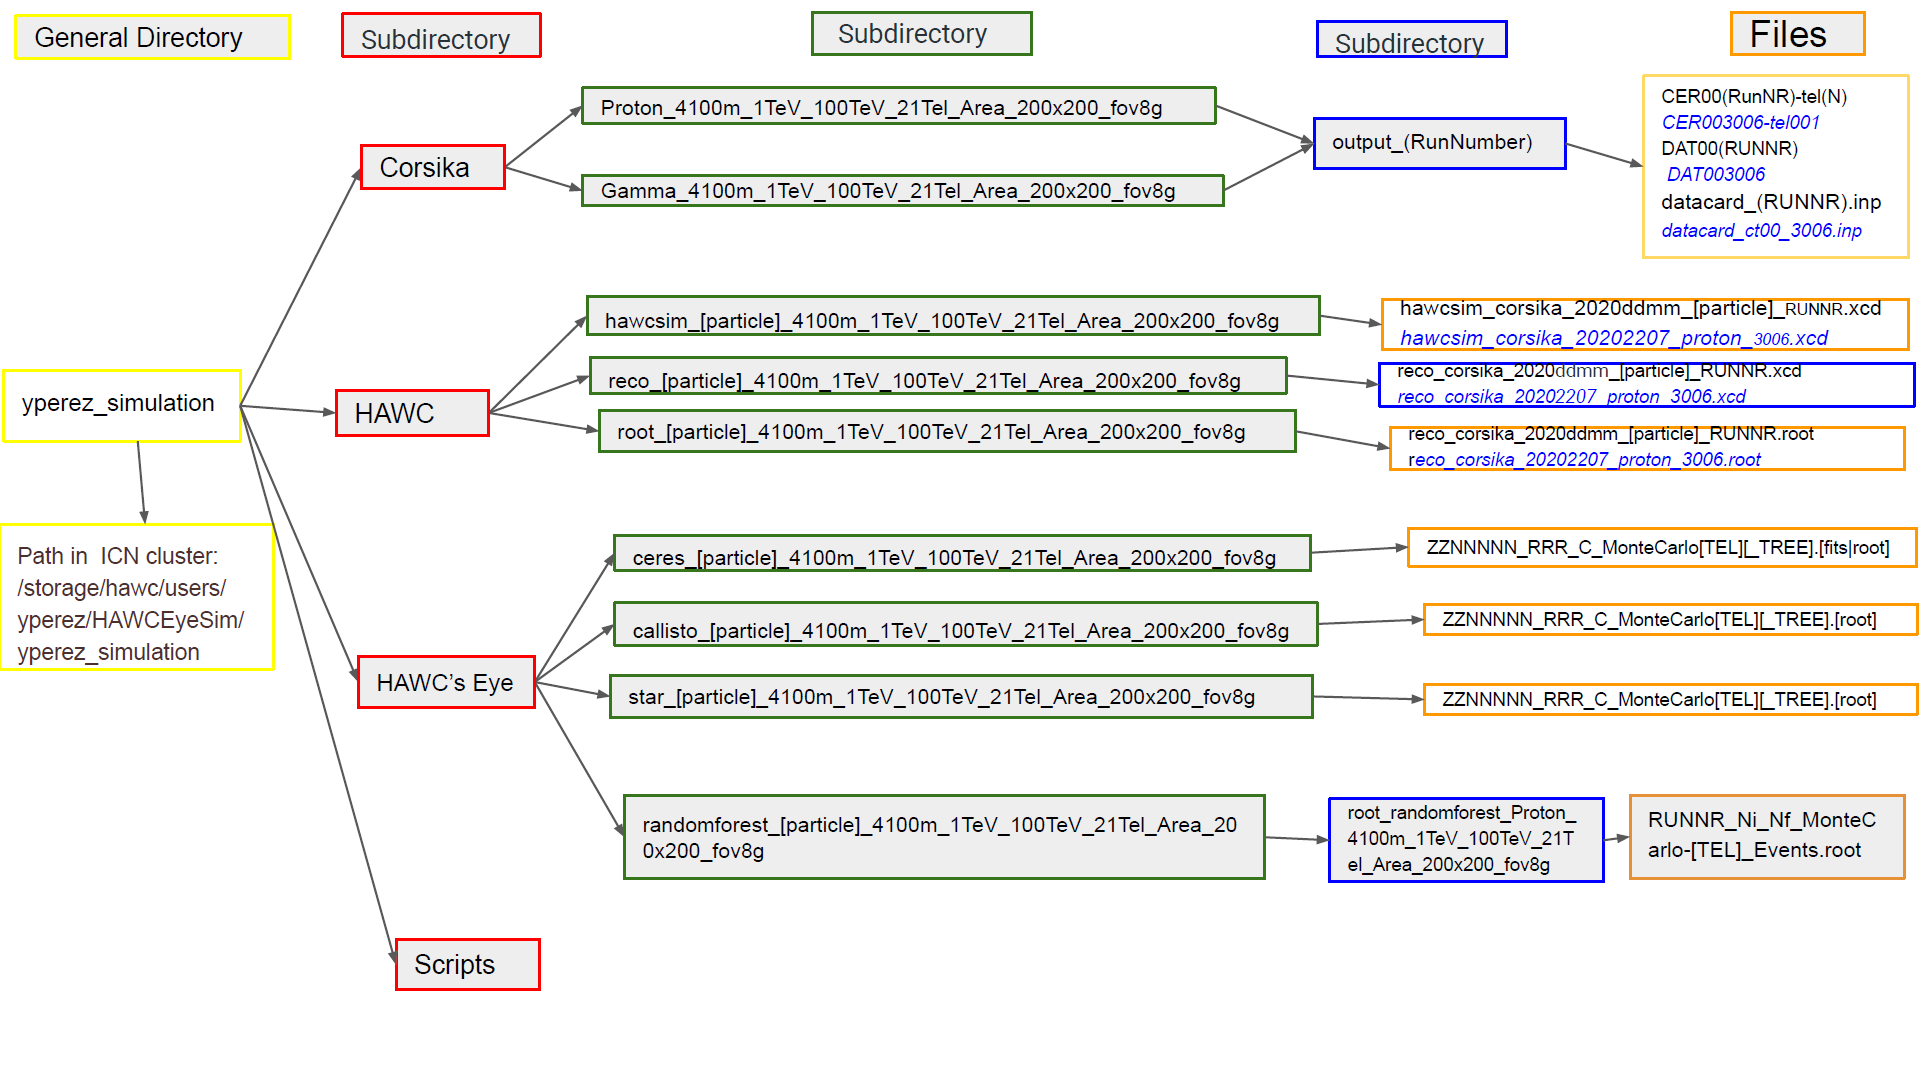

In [ ]:
Image('/content/HAWC.png')

# Motivación

Procesamiento de imágenes:


*   Primer paso de calibración (Callisto), donde se generan imagenes calibradas con valores de:
  *   tiempo de llegada por píxels,
  *   e intensidad del brillo de cada píxel.
*   Segundo paso de limpieza de las imágenes, se limpia el ruido de fondo del cielo nocturno.
*   Por último se calculan los parámetros de estas imagenes (Star).

CALLISTO - CALibrate LIght Signals and Time Offsets

STAR - STandard Analysis and Reconstruction

# Observaciones

La limpieza de imagen se describe con más detalles.
*  El parámetro MinCount determina el número mínimo de píxeles necesarios para que una isla sobreviva
*  MinSize el tamaño mínimo (señal integrada).
*  DeltaT definió la diferencia de tiempo entre píxeles vecinos en nanosegundos por grado.

STAR
parámetros:
Mincount = 0;
Minsize = 25;
Deltat = 2.5;

# Propuesta

 Propuesta para el procesamiento de imágenes:


*   Adquisición de eventos MonteCarlo (archivos en root cern) para cada telescopio (1-55)
*   Entrenar una modelo de aprendizaje automático para comparar la limpieza en las imágenes. Con la finalidad de identificar que parte de la imágen correspone a la lluvia cósmica y que parte pertenece al fondo del cielo nocturno (ruido).


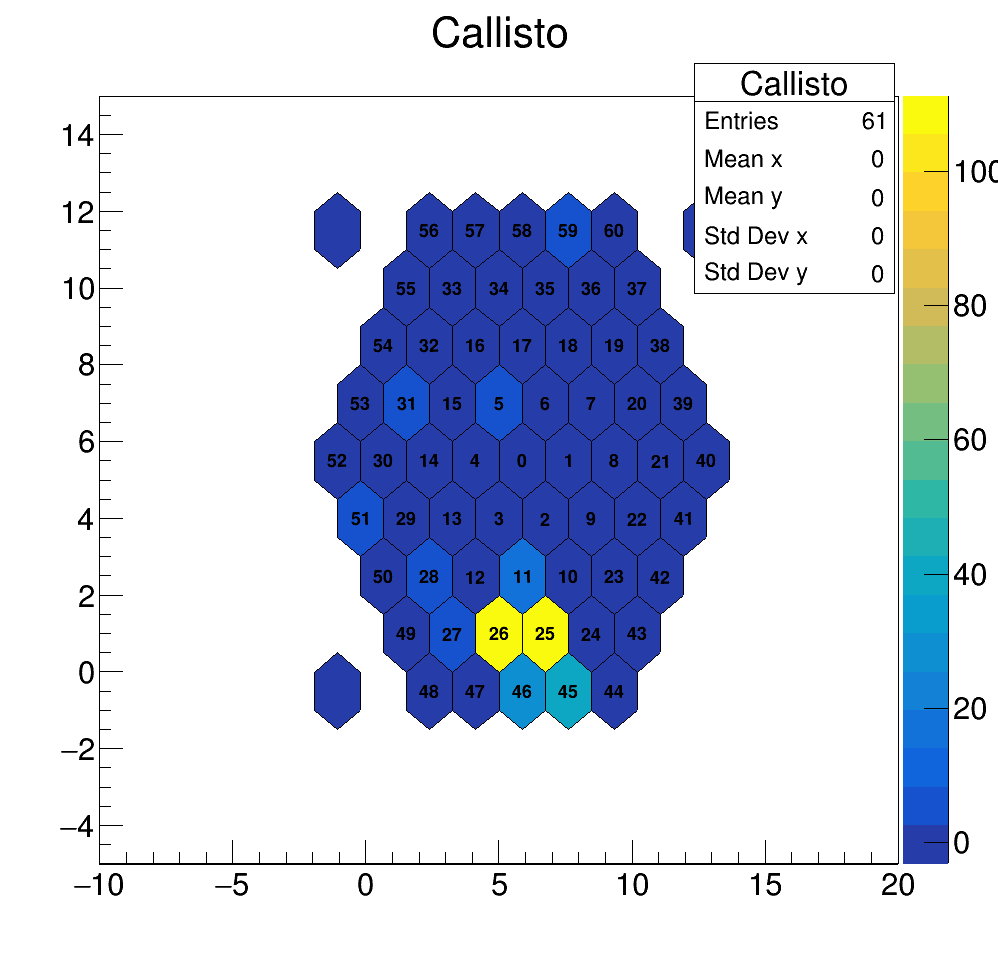

In [ ]:
Image('/content/CallistoTel001_Run002_Entry001_55Tels.png')


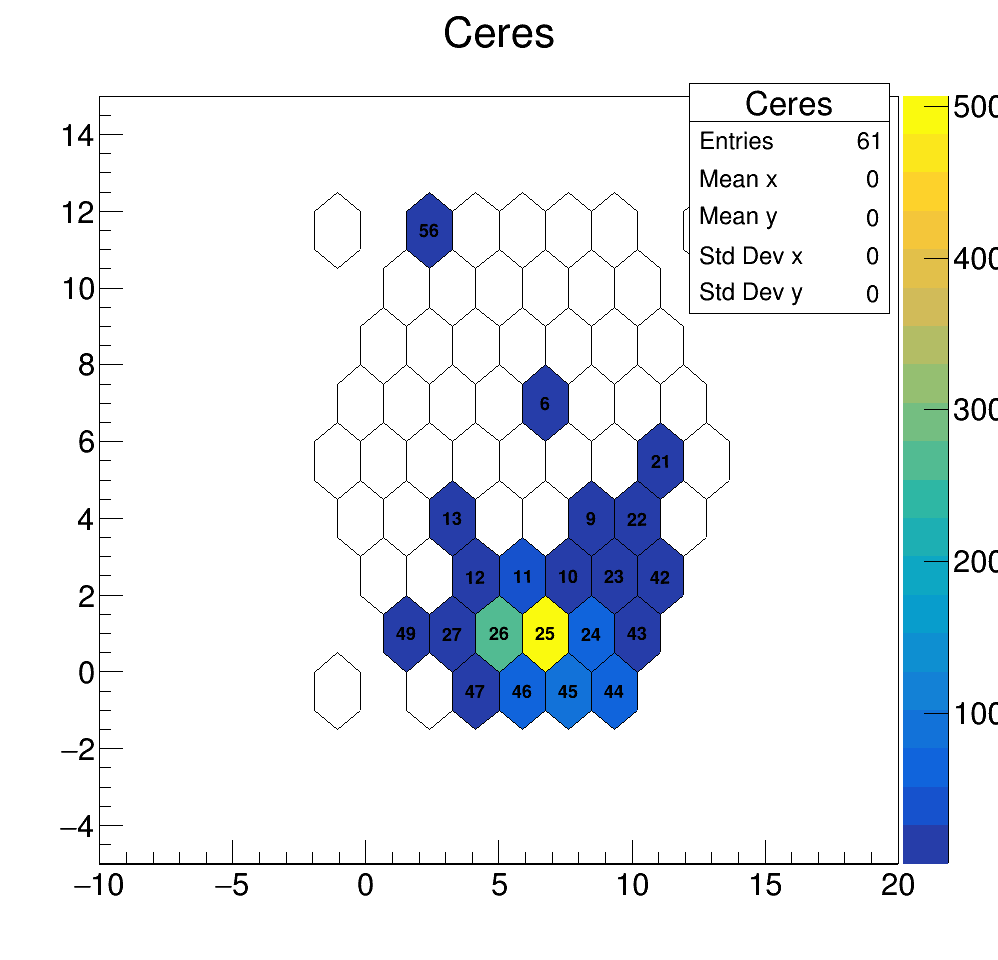

In [ ]:
Image('/content/Ceres_Tel001_Run002_Entry001_55Tels.png')

In [ ]:
df = pd.read_csv('/content/example_callisto_gamma_4100m_1TeV_100TeV_55Tel_Area_250x250_fov8g.csv',sep=" ",usecols=['fDAQEvtNumber', 'fRunNumber', 'fId','fPhot','fArrivalTime'],dtype={'fId':str})
#
df['fRing']=0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9965440 entries, 0 to 9965439
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   fDAQEvtNumber  int64  
 1   fRunNumber     int64  
 2   fId            object 
 3   fPhot          float64
 4   fArrivalTime   float64
 5   fRing          int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 456.2+ MB


In [ ]:
# Valores nulos -> 0
df = df.fillna(0)

In [ ]:
df = df[:100000]

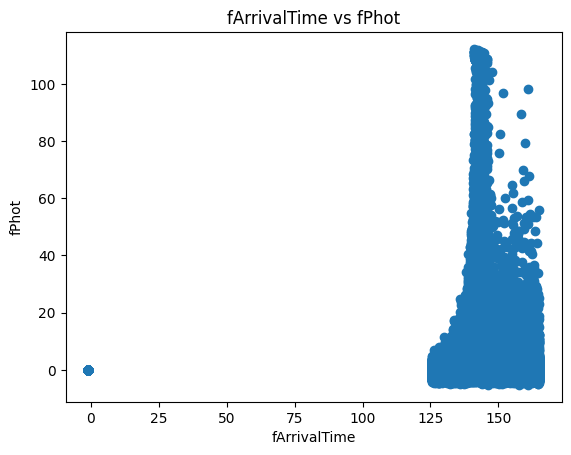

In [ ]:
plt.scatter(df['fArrivalTime'],df['fPhot'])
plt.title("fArrivalTime vs fPhot")
plt.xlabel("fArrivalTime")
plt.ylabel("fPhot")
plt.show()

<ipython-input-11-afbee8f19a40>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.displot(x="fPhot",


[]

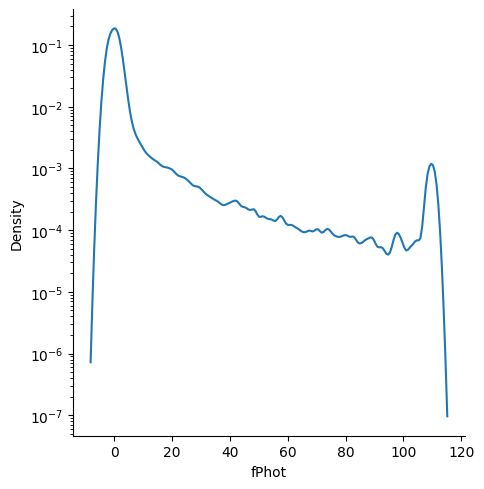

In [ ]:
sns.displot(x="fPhot",
                data=df, palette='deep',kind="kde")
plt.semilogy()

<ipython-input-12-d641094b780d>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.displot(x="fArrivalTime",


[]

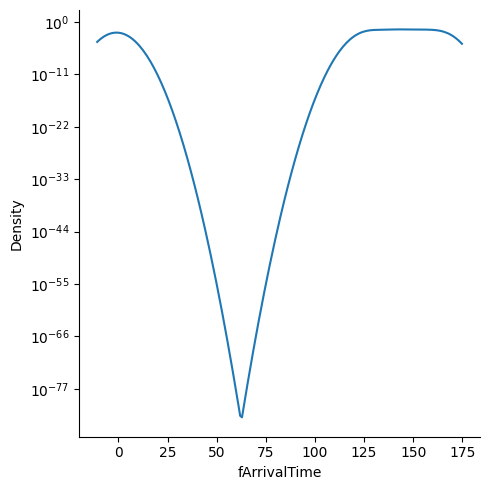

In [ ]:
sns.displot(x="fArrivalTime",
                data=df, palette='deep',kind="kde")
plt.semilogy()

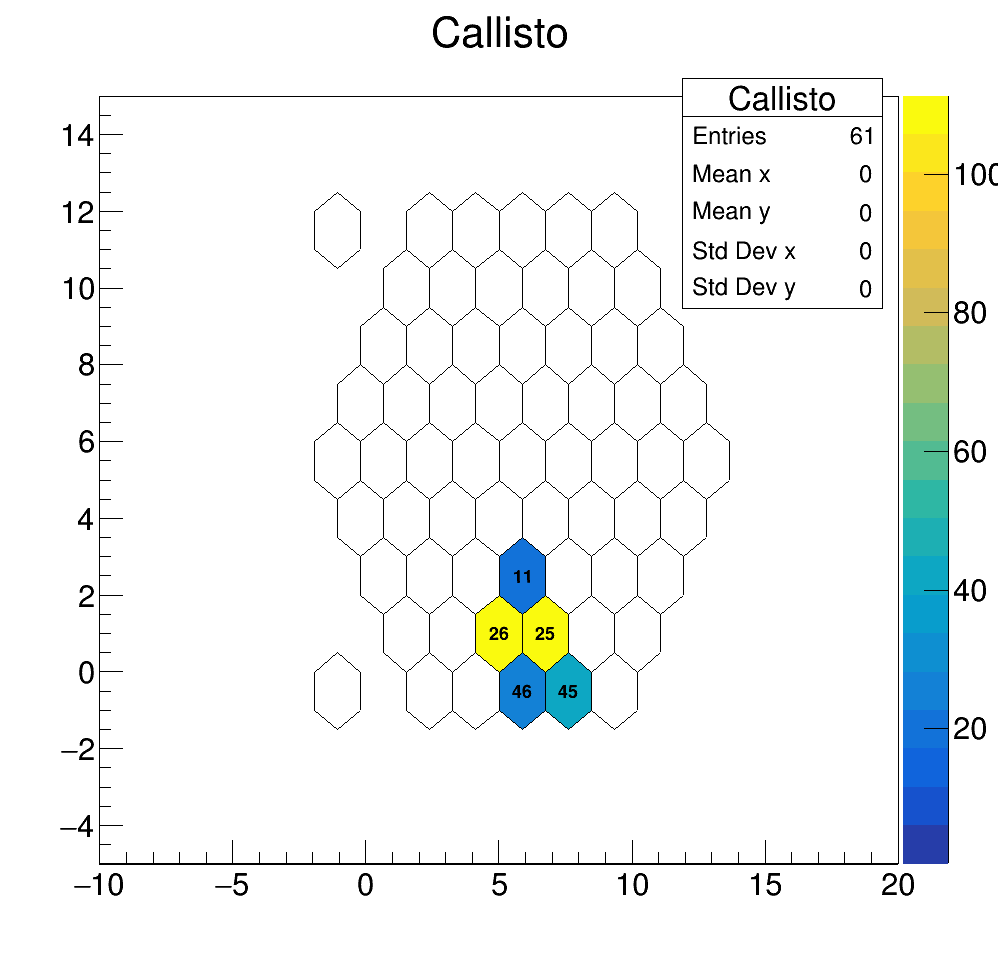

In [ ]:
Image('/content/Cleaning_Tel001_Run002_Entry001_55Tels.png')

<ipython-input-14-bcbf2ff995da>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


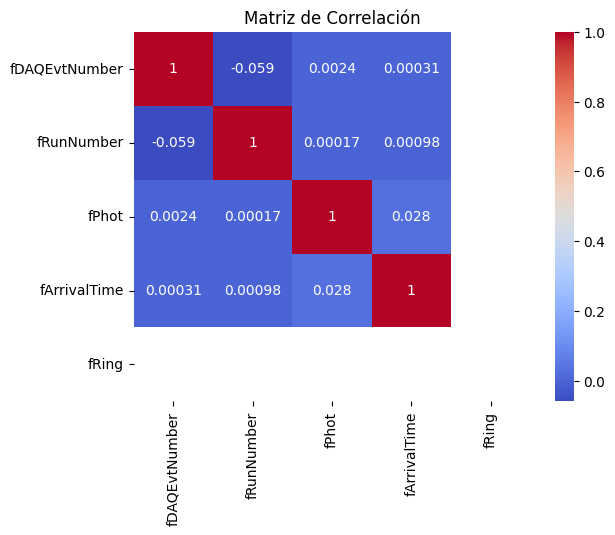

In [ ]:
#Matriz de correlación
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

In [ ]:
# Muestras como señal o ruido
df['is_noise'] = df['fPhot'] < 25
y = df['is_noise'].astype('int')  # 0/1

In [ ]:
# Entrenamiento(80%) y prueba (20%)
X = df.drop(['fPhot', 'is_noise'], axis=1)  # Excluyen fPhot y is_noise
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Crear un modelo SVM (Support Vector Machine)
svm_model = SVC(kernel='linear', C=1)  # Kernel lineal y parámetro de regularización C

# Entrenar
svm_model.fit(X_train, y_train)


SVC(C=1, kernel='linear')

In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = svm_model.predict(X_test)

In [ ]:
# Precisión
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo SVM: {accuracy }')

# Informe
print(classification_report(y_test, y_pred))

Precisión del modelo SVM: 0.9823
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       354
           1       0.98      1.00      0.99     19646

    accuracy                           0.98     20000
   macro avg       0.49      0.50      0.50     20000
weighted avg       0.96      0.98      0.97     20000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
